In [1]:
import os
import glob

import spacy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
en = spacy.load('en_core_web_sm')

In [3]:
DATASETS_HOME = '../datasets'

train_df = pd.read_csv(os.path.join(DATASETS_HOME, 'home-depot/train.csv'))
train_df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [4]:
train_df.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [5]:
min_rel, max_rel = train_df['relevance'].min(), train_df['relevance'].max()
print(min_rel, max_rel)

1.0 3.0


In [6]:
X = train_df[['product_title', 'search_term', 'product_description']] 
y = train_df['relevance']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,)

In [8]:
def preprocess(text):
    # TODO:
    # remove punctuation
    # try spacy stopwords, or something else
    
    return text


# TODO: Try BM25


tfidf_model = TfidfVectorizer(
    strip_accents='ascii',
    max_df=0.95,
    min_df=0.01,
    max_features=5000
).fit(X_train['product_description'])

In [9]:
def cosim(queries, candidates):
    return cosine_similarity(queries, candidates)

In [10]:
def change_pred_range(pred, low=1.0, high=3.0):
    return pred / pred.max() * (high-low) + low

In [11]:
# MSE
def mse(pred, target):
    return np.mean((pred.diagonal() - target) ** 2)

In [12]:
# when using product title; train set
k = 5000

tfidf_candidates = tfidf_model.transform(X_train['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_train['product_title'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_train[:k])

0.807312163146821

In [13]:
# when using product title; test set
k = 5000

tfidf_candidates = tfidf_model.transform(X_test['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_test['product_title'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_test[:k])

0.77632950867199

In [14]:
# when using search term; train set
k = 5000

tfidf_candidates = tfidf_model.transform(X_train['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_train['search_term'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_train[:k])

1.3951537667501885

In [15]:
# when using search term; test set
k = 5000

tfidf_candidates = tfidf_model.transform(X_test['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_test['search_term'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_test[:k])

1.4170490069134252

In [16]:
# visual inspection of quality
# randomly sample about 20 examples

k = 20

idxs = np.random.randint(0, len(X_test), size=(k,))
X_test.iloc[idxs][['product_title', 'search_term', 'product_description']]

,product_title,search_term,product_description
9048,ECHO 2-Cycle 22.8 CC Straight Shaft Gas Trimmer,trimmer echo,Get plenty of power and reliable performance f...
17140,Hampton Bay 10 ft. Stainless Steel Line-Voltag...,track lighting track,Design this Hampton Bay 10 ft. Brushed Steel L...
72014,Apache Mills Gray 24 in. x 36 in. Vinyl Foam C...,mills pride doors 1993,The Apache Mills Gray 24 in. x 36 in. Vinyl Fo...
38566,Brady 10 in. x 14 in. Plastic Notice Keep This...,safety signs,Post essential notices with the Brady 10 in. x...
793,Vigo Kitchen Soap Dispenser in Stainless Steel,sink soap dispenser,Create a sophisticated sink design with a Vigo...
33138,GE 24 in. 3.0 cu. ft. Electric Range in Stainl...,24 stainless gas range,The GE 24 in. Freestanding Electric Range feat...
34149,Summit Appliance 5.1 cu. ft. Mini Refrigerator...,2.3 cu mini fridge,Summit brings quality and value to counter hei...
71832,Illumine 3 Light Tiffany Peacock Feather Inver...,tiffany peacock pendant,The Meyda Tiffany brand is inspired by the Ita...
13214,FLEX-Drain 4 in. x 25 ft. Solid Polypropylene ...,4 inch drain,FLEX-Drain helps you get the job done faster a...
32890,KitchenAid 24 in. Front Control Dishwasher in ...,kitchenaide dishwasher,This powerful front control dishwasher feature...


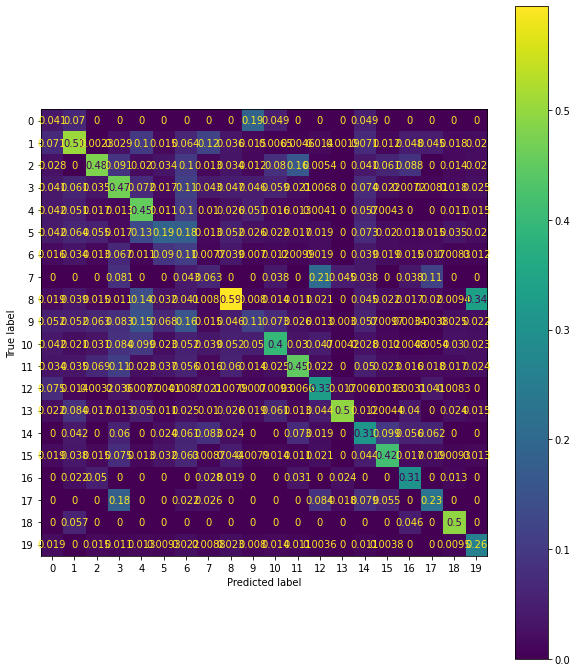

In [17]:
tfidf_candidates = tfidf_model.transform(X_test.iloc[idxs]['product_description'])
tfidf_queries = tfidf_model.transform(X_test.iloc[idxs]['product_title'])
y_pred_rand = cosim(tfidf_queries, tfidf_candidates)


ConfusionMatrixDisplay(y_pred_rand).plot()
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.show()

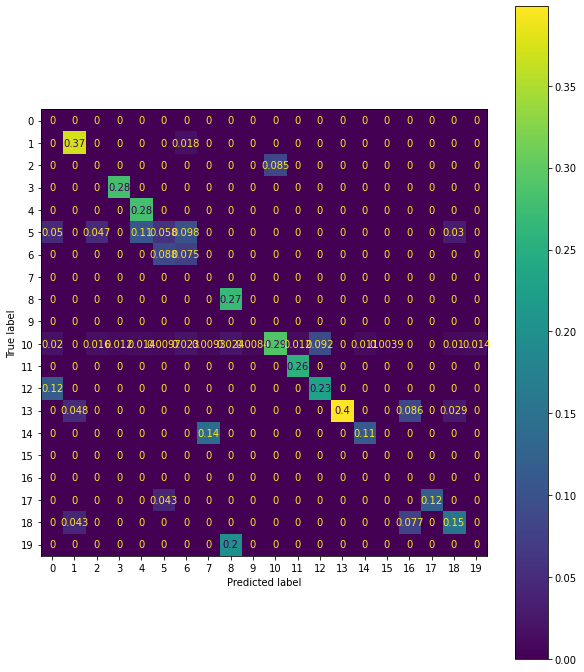

In [18]:
tfidf_candidates = tfidf_model.transform(X_test.iloc[idxs]['product_description'])
tfidf_queries = tfidf_model.transform(X_test.iloc[idxs]['search_term'])
y_pred_rand = cosim(tfidf_queries, tfidf_candidates)


ConfusionMatrixDisplay(y_pred_rand).plot()
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.show()

## Resume Dataset - 1

In [143]:
with open(os.path.join(DATASETS_HOME, 'resume-corpus/skills_it.txt'), 'r') as f:
    jds = f.read()

In [144]:
job_descriptions = {}

for i, jd in enumerate(jds.split('::::::\n::::::\n')):
    # first occurrence of ':::'
    idx1 = jd.find(':::')
    idx2 = jd.find(':::', idx1+3)
    role = jd[idx1+3: idx2].split(';')[0]
    job_descriptions[role] = role + ' ' + jd[idx2+3:]

In [146]:
# all the text files
files = glob.glob(os.path.join(DATASETS_HOME, 'resume-corpus/resumes_corpus/*.txt'))
role_info = []
for file in files:
    with open(file, encoding='latin-1', errors='replace') as f:
        role_info.append(f.read())

In [147]:
len(role_info)

29783

In [148]:
# tfidf_model = TfidfVectorizer(
#     encoding='utf-8',
#     strip_accents='ascii',
#     max_df=0.90,
#     min_df=0.01,
#     max_features=4096
# ).fit(role_info)

# using stopwords
tfidf_model_stopwords = TfidfVectorizer(
    encoding='latin-1',
    stop_words=en.Defaults.stop_words,
    strip_accents='ascii',
    max_df=0.95,
    min_df=5,
    max_features=1024
).fit(role_info + list(job_descriptions.values()))


# new_tfidf_model = TfidfVectorizer(
#     encoding='latin-1',
#     strip_accentjobs='ascii',
#     decode_error='replace',
#     max_df=0.95,
#     min_df=0.01,
#     max_features=4096
# )

/home/kirito/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'nt', 've'] not in stop_words.
  warnings.warn(


In [150]:
candidate = tfidf_model_stopwords.transform(['Senior Systems Administrator'])
_, idxs = np.where(candidate.toarray() != 0)
tfidf_model_stopwords.get_feature_names_out()[idxs]

array(['administrator', 'senior', 'systems'], dtype=object)

In [151]:
len(job_descriptions)

648

In [152]:
tfidf_candidates = tfidf_model_stopwords.transform(list(job_descriptions.values()))

In [153]:
tfidf_candidates.toarray()

array([[0.        , 0.        , 0.        , ..., 0.21163211, 0.        ,
        0.        ],
       [0.        , 0.18305219, 0.        , ..., 0.        , 0.25436226,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.23548842, 0.03677853,
        0.16014908],
       ...,
       [0.01103479, 0.05374118, 0.00274602, ..., 0.09690358, 0.14331332,
        0.01882898],
       [0.01214259, 0.05174431, 0.01208679, ..., 0.06093252, 0.06888081,
        0.01973262],
       [0.00635699, 0.05108324, 0.00253111, ..., 0.0218742 , 0.06661801,
        0.00619835]])

In [154]:
(tfidf_candidates.toarray() == 0).sum()
_, idxs = np.where(tfidf_candidates[3, :].toarray() != 0)

print(idxs)
tfidf_model_stopwords.get_feature_names_out()[idxs]

[   1   21   22   24   25   31   33   35   36   37   39   40   42   45
   49   51   56   61   70   75   76   78   86   87   90   91   99  101
  102  103  104  105  106  107  112  113  116  117  119  126  132  133
  137  142  157  158  160  164  174  178  191  192  193  194  195  196
  204  214  215  216  217  220  227  229  233  237  238  240  245  249
  250  254  255  256  257  265  266  275  276  279  282  284  287  293
  296  306  308  315  317  318  321  328  329  332  333  334  337  339
  342  347  348  350  355  359  362  363  365  368  374  392  393  403
  404  412  413  414  416  418  421  425  427  430  432  446  456  457
  458  463  467  468  469  470  471  475  478  486  489  493  495  497
  507  508  518  519  520  534  535  542  546  551  557  558  559  562
  563  566  567  568  569  572  573  574  575  577  580  583  591  604
  614  615  619  621  624  625  628  629  631  633  638  648  649  652
  654  655  661  664  665  666  670  672  673  678  679  680  681  689
  690 

array(['10', '2012', '2013', '2015', '2016', 'ability', 'access',
       'account', 'accounts', 'achieve', 'actions', 'active', 'activity',
       'added', 'administration', 'administrator', 'alerts', 'analytical',
       'apache', 'application', 'applications', 'appropriate', 'aspects',
       'assessment', 'assets', 'assigned', 'authentication', 'authorized',
       'auto', 'automate', 'automated', 'automation', 'availability',
       'aws', 'backup', 'backups', 'based', 'bash', 'basis', 'boot',
       'build', 'building', 'capacity', 'center', 'client', 'clients',
       'cloud', 'code', 'communication', 'company', 'configuration',
       'configurations', 'configure', 'configured', 'configuring',
       'connectivity', 'control', 'create', 'created', 'creating',
       'creation', 'critical', 'customer', 'customized', 'daily', 'data',
       'database', 'day', 'december', 'delivery', 'dell', 'deploy',
       'deployed', 'deploying', 'deployment', 'desk', 'desktop',
       'developi

In [168]:
with open(os.path.join(DATASETS_HOME, 'resume-corpus/resumes_corpus/00209.txt'), errors='replace') as f:
    text = f.read()
#     print(text)
    query = tfidf_model_stopwords.transform([text])

_, idxs = np.where(query.toarray() != 0)
print(tfidf_model_stopwords.get_feature_names_out()[idxs])
# scores = cosine_similarity(query, tfidf_candidates)

['10' '10g' '11g' '2010' '2012' '2013' '2014' 'activities' 'added' 'admin'
 'administration' 'administrator' 'analysis' 'application' 'applications'
 'applied' 'appropriate' 'area' 'associate' 'backup' 'based' 'basic'
 'business' 'capacity' 'care' 'class' 'client' 'communication' 'company'
 'configuration' 'configure' 'configured' 'configuring' 'coordinated'
 'created' 'data' 'database' 'databases' 'design' 'development'
 'different' 'education' 'end' 'enhancements' 'enterprise' 'environment'
 'environments' 'files' 'firewall' 'fl' 'flash' 'generated' 'group'
 'handle' 'hardware' 'hat' 'health' 'hl' 'identified' 'inc' 'including'
 'install' 'installation' 'installed' 'integration' 'integrity'
 'interactive' 'issues' 'jobs' 'key' 'linux' 'log' 'maintain'
 'maintenance' 'manage' 'managed' 'management' 'manager' 'md' 'migrated'
 'monitor' 'monitored' 'monitoring' 'network' 'new' 'operating' 'oracle'
 'os' 'packages' 'patch' 'patches' 'perform' 'performance' 'performed'
 'personnel' 'physi

In [169]:
scores = cosine_similarity(query, tfidf_candidates)

In [170]:
list(job_descriptions.keys())[np.argmax(scores)]

'Unix/Linux Systems Administrator'

In [172]:
# pickle
import joblib

joblib.dump(tfidf_model_stopwords, '../checkpoints/tfidf-1024-stopwords.joblib')

['tfidf-1024-stopwords.pkl']

In [184]:
pointwise = query.toarray() * tfidf_candidates.toarray()
idxs = np.argsort(pointwise, axis=1)[...,::-1]
pw_sorted = np.sort(pointwise, axis=1)[...,::-1]

In [185]:
idxs

array([[ 51, 826, 899, ..., 663, 662,   0],
       [ 51, 369, 904, ..., 658, 657,   0],
       [ 51, 546, 469, ..., 673, 672,   0],
       ...,
       [826, 574, 468, ..., 645, 644,   0],
       [468, 575, 899, ..., 647, 646,   0],
       [654, 238, 239, ..., 640, 639,   0]])

In [186]:
pw_sorted

array([[0.06131191, 0.01771155, 0.01043244, ..., 0.        , 0.        ,
        0.        ],
       [0.04460635, 0.01344653, 0.01267645, ..., 0.        , 0.        ,
        0.        ],
       [0.02436547, 0.01763621, 0.01445491, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04575112, 0.00734748, 0.00698643, ..., 0.        , 0.        ,
        0.        ],
       [0.01237119, 0.01202026, 0.00977387, ..., 0.        , 0.        ,
        0.        ],
       [0.09269988, 0.04511817, 0.02823888, ..., 0.        , 0.        ,
        0.        ]])

In [189]:
sorted_vocab = tfidf_model_stopwords.get_feature_names_out()[idxs]

In [212]:
from collections import defaultdict


hm = defaultdict(int)
n = 10

for i, vocab_list in enumerate(sorted_vocab):
    idxs_i = np.where(pw_sorted[i] > 0)[0]
    for j, word in enumerate(vocab_list[idxs_i][:n]):
        hm[word] += pw_sorted[i][idxs_i[j]] / 4.0
        
print(hm.keys())

dict_keys(['administrator', 'security', 'support', 'user', 'managed', 'users', 'systems', 'fl', 'provided', 'management', 'system', '10', 'network', 'server', 'recovery', 'backup', 'upgrades', 'linux', 'installed', 'hat', 'red', 'os', 'servers', 'patches', 'installation', 'issues', 'jobs', 'inc', 'including', 'environment', 'configuration', 'new', 'firewall', 'md', '2014', 'oracle', 'install', 'solaris', 'configured', 'upgraded', 'administration', 'required', 'upgrade', 'database', 'integrity', 'databases', 'communication', 'data', 'training', 'admin', 'application', 'maintain', '2012', 'manager', 'area', 'applied', 'troubleshooting', 'company', '2013', 'space', 'vmware', 'supported', 'physical', 'operating', 'hardware', 'production', 'worked', 'associate', 'perform', 'education', 'service', 'monitoring', 'technical', 'public', 'personnel', 'virtual', 'basic', 'end', '10g', 'enterprise', 'configure', 'manage', 'key', 'spring', 'created', 'migrated', '11g', 'vendors', 'log', 'care', 'an

In [213]:
np.argsort(tfidf_candidates, axis=1)[...,::-1]
tfidf_model_stopwords.get_feature_names_out()

AxisError: axis 1 is out of bounds for array of dimension 1